In [1]:
# https://www.tensorflow.org/tutorials/generative/cvae
# conda activate ml

from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import os
from sklearn.linear_model import LogisticRegression
import h5py

from scipy.ndimage import gaussian_filter1d

In [2]:
cdict = {'image_size': 47,
         'nkernels': [16, 32],
         'loss': 'l2', #'cross_ent', 'l2'
         'sigma_l2': 0.1,
         'latent_dim': 10,
         'smax': 1000,
         'smin': 400,
         'epochs': 30,
        }

use_priors = False
add_npixels = 1
#IMAGE_SIZE = 110 + add_npixels
IMAGE_SIZE = cdict['image_size']
MAXV = 30
stride = 2
kernel = 3
batch_size = 32
nkernels_list = cdict['nkernels']
loss_method = cdict['loss']
smax = cdict['smax']
smin = cdict['smin']

latent_dim = cdict['latent_dim']
epochs = cdict['epochs']
num_examples_to_generate = 16
save_model = False
sigma_l2 = cdict['sigma_l2']

# set the dimensionality of the latent space to a plane for visualization later
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14

np.random.seed(seed=5)

In [3]:
#s0 = 111
#s0 = 39
s0 = IMAGE_SIZE
s1 = ((s0 - 1)/2)
s2 = ((s1 - 1)/2)
#s3 = ((s2 - 1)/2)
d1 = ((s2 - 1) * 2 + 3)
d2 = ((d1 - 1) * 2 + 3)
#d3 = ((d2 - 1) * 2 + 3)
print('layer 0:', s0)
print('layer 1: padding 0, stride 2:', s1)
print('layer 2: padding 0, stride 2:', s2)
#print('layer 3: padding 0, stride 2:', s3)
print('dlayer 1: padding 0 outpad 1, stride 2:', d1)
print('dlayer 2: padding 0 outpad 1, stride 2:', d2)
#print('dlayer 3: padding 0 outpad 1, stride 2:', d3)

deconv_len = int(s2)

layer 0: 47
layer 1: padding 0, stride 2: 23.0
layer 2: padding 0, stride 2: 11.0
dlayer 1: padding 0 outpad 1, stride 2: 23.0
dlayer 2: padding 0 outpad 1, stride 2: 47.0


In [4]:
def model_descr_str(cdict):
    res = '%s_loss' % cdict['loss']
    res += '_image_size_%i_latent_dim_%i' % (cdict['image_size'], cdict['latent_dim'])
    res += '_nkernels_'
    for n in cdict['nkernels']:
        res += '%i-' % n
    return res[:-1]

def save_vae_model(model, cdict , fmt='h5', path='../models/'):
    descr_str = model_descr_str(cdict)
    if not os.path.isdir(path):
        os.makedirs(path)
    for md in ['encoder', 'decoder']:
        mdl_fn = '%s/model_%s_%s' % (path, descr_str, md)
        if fmt == 'h5':
            mdl_fn += '.h5'
        print('Saving %s to file:' % md)
        print(mdl_fn)
        if md == 'encoder':
            model.encoder.save(mdl_fn)
        else:
            model.decoder.save(mdl_fn)

def load_vae_model(cdict, fmt='h5', path='../models/'):
    descr_str = model_descr_str(cdict)
    for md in ['encoder', 'decoder']:
        mdl_fn = '%s/model_%s_%s' % (path, descr_str, md)
        if fmt == 'h5':
            mdl_fn += '.h5'
        if md == 'encoder':
            enc_mdl = tf.keras.models.load_model(mdl_fn)
        else:
            dec_mdl = tf.keras.models.load_model(mdl_fn)
    return CVAE(latent_dim, encoder=enc_mdl, decoder=dec_mdl)


In [52]:

# functions and classes
def preprocess_images(images, shades=True, thres=0., transp=1., maxv=MAXV, add_npixels=0):
    images = images.astype('float32')
    images[images < maxv * thres] = 0.
    images *= transp
    n, d1, d2 = images.shape
    
    images = images.reshape((n, d1, d2, 1))
    if add_npixels > 0:
        # also possible to use concatenate
        res = np.zeros((n, d1+add_npixels, d2+add_npixels, 1), dtype=np.float32)
        res[:,:d1, :d2, :] = images
        images = res
        
    if maxv is not None:
        images = np.minimum(images/maxv, 1.)
    if shades:
        return images
    else:
        return np.where(images > .5, 1.0, 0.0).astype('float32')


class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim, encoder=None, decoder=None):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    
    if encoder is None:
        enc_layers_list = [tf.keras.layers.InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1))]
        for nkernels in nkernels_list:
            enc_layers_list.append(tf.keras.layers.Conv2D(
                    filters=nkernels, kernel_size=kernel, strides=stride, 
                    activation='relu', padding='valid'))
        enc_layers_list.append(tf.keras.layers.Flatten())
        # No activation
        enc_layers_list.append(tf.keras.layers.Dense(latent_dim + latent_dim),)


        self.encoder = tf.keras.Sequential(enc_layers_list)
    else:
        self.encoder = encoder
    
    if decoder is None:
        dec_layers_list = [tf.keras.layers.InputLayer(input_shape=(latent_dim,))]
        dec_layers_list.append(
            tf.keras.layers.Dense(units=deconv_len*deconv_len*32, activation=tf.nn.relu))
        dec_layers_list.append(
            tf.keras.layers.Reshape(target_shape=(deconv_len, deconv_len, 32)))
        for nkernels in nkernels_list[::-1]:
            dec_layers_list.append(tf.keras.layers.Conv2DTranspose(
                    filters=nkernels, kernel_size=kernel, strides=stride, 
                    padding='valid', activation='relu'))
        # No activation
        dec_layers_list.append(tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=1, padding='same',
                    activation=None))

        self.decoder = tf.keras.Sequential(dec_layers_list)
    else:
        self.decoder = decoder

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=False)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x, loss_method='cross_ent', sigma_l2=0.1,
                mean_prior=0., logvar_prior=0.):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_pred = model.decode(z)
    if loss_method == 'cross_ent':
        pred_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_pred, labels=x)
    elif loss_method == 'l2':
        pred_loss = 0.5 * (x - x_pred)**2 / sigma_l2**2
    logpx_z = -tf.reduce_sum(pred_loss, axis=[1, 2, 3])
    
    logpz = log_normal_pdf(z, mean_prior, logvar_prior)
    logqz_x = log_normal_pdf(z, mean, logvar)
    # this is ELBO = - log p(x) + KL
    return -tf.reduce_mean(logpx_z + logpz - logqz_x) # -(log p(x) - KL)


@tf.function
def train_step(model, x, optimizer, loss_method='cross_ent', sigma_l2=sigma_l2,
              mean_prior=0., logvar_prior=0.):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, loss_method=loss_method, sigma_l2=sigma_l2,
                           mean_prior=mean_prior, logvar_prior=logvar_prior)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

def predicted_images(model, images):
    mean, logvar = model.encode(images)
    z = model.reparameterize(mean, logvar)
    return model.sample(z)

    
def generate_and_save_images(model, epoch, test_sample, folder='plots', 
                             save=True, show=True, maxv=MAXV, title=''):
    predictions = predicted_images(model, test_sample)
    fig = plt.figure(figsize=(6, 6))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
        plt.colorbar()
    
    plt.suptitle(title)
    # tight_layout minimizes the overlap between 2 sub-plots
    if save:
        plt.savefig('{}/image_at_epoch_{:04d}.png'.format(folder, epoch))
    if show:
        plt.show()

def display_image(epoch_no, folder='plots'):
    return PIL.Image.open('{}/image_at_epoch_{:04d}.png'.format(folder, epoch_no))

def plot_latent_images(model, n, digit_size=IMAGE_SIZE):
    """Plots n x n digit images decoded from the latent space."""

    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
          z = np.array([[xi, yi]])
          x_decoded = model.sample(z)
          digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
          image[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()

def plot_label_clusters(z_mean, labels, inds=[0,1], new_fig=True, **args):
    # display a 2D plot of the digit classes in the latent space
    if new_fig:
        plt.figure(figsize=(8, 6))
    plt.scatter(z_mean[:, inds[0]], z_mean[:, inds[1]], c=labels, **args)
    if new_fig:
        plt.colorbar()
        plt.xlabel("$x_%i$" % (inds[0] + 1))
        plt.ylabel("$x_%i$" % (inds[1] + 1))
        #plt.show()


In [6]:
%%time
# variables
plot_folder = 'plots'
if not os.path.isdir(plot_folder):
    os.makedirs(plot_folder)

folder = '/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/Prod5_square_images/'
ev_types = ['proton', 'gamma-diffuse']
n_events = 5*10**4
#n_events = 1000
data_key = 'image_mask' # 'image', 'image_mask'
image_keys = ['image', 'image_mask']
pars_keys = ['CR_type']
y_key = 'CR_type'
data0 = None
# load images
for k, event_type in enumerate(ev_types):
    print('load %s images' % event_type)
    fn = folder + '%s_%i_images.h5' % (event_type, n_events)
    with h5py.File(fn, 'r') as f:
        for key in f.keys():
            if key not in pars_keys and key not in image_keys:
                pars_keys.append(key)
        if data0 is None:
            dims = f[data_key].shape
            ntot = dims[0] * len(ev_types)
            data0 = np.zeros((ntot, dims[1], dims[2]), dtype=np.float32)
        fill_inds = list(range(dims[0] * k, dims[0] * (k + 1)))
        data0[fill_inds] = f[data_key][:]


# load meta data
pars_dict = {key:np.zeros(ntot, dtype=np.float32) for key in pars_keys}
for k, event_type in enumerate(ev_types):
    fill_inds = list(range(dims[0] * k, dims[0] * (k + 1)))
    fn = folder + '%s_%i_images.h5' % (event_type, n_events)
    with h5py.File(fn, 'r') as f:
        for key in pars_dict.keys():
            if key == 'CR_type':
                pars_dict[key][fill_inds] += int(event_type == 'proton')
            else:
                pars_dict[key][fill_inds] = f[key][:]



load proton images
load gamma-diffuse images
CPU times: user 1.6 s, sys: 6.15 s, total: 7.76 s
Wall time: 7.76 s


In [7]:
# mask size
smask = (pars_dict['hillas_intensity'] < smax) & (pars_dict['hillas_intensity'] > smin)
data_masked = data0[smask]

In [8]:
# mask metadata
for key in pars_dict.keys():
    pars_dict[key] = pars_dict[key][smask]


In [9]:
# crop images
di = int((IMAGE_SIZE - 1) / 2)
nn, nx, ny = data_masked.shape
norm = np.sum(data_masked, axis=(1,2)) + 1.e-15
ix = np.round(np.sum(np.sum(data_masked, axis=2) * np.arange(nx), axis=1)/norm).astype(int)
ix = np.maximum(ix, di)
ix = np.minimum(ix, nx - di)

iy = np.round(np.sum(np.sum(data_masked, axis=1) * np.arange(ny), axis=1)/norm).astype(int)
iy = np.maximum(iy, di)
iy = np.minimum(iy, ny - di)
res_arr = np.zeros((nn, 2*di, 2*di))
for i in range(nn):
    res_arr[i] = data_masked[i, ix[i]-di:ix[i]+di, iy[i]-di:iy[i]+di]
print(res_arr.shape)

(15571, 46, 46)


In [10]:
if 0:
    for i in range(10):
        if pars_dict['hillas_intensity'][i] < 200 or 1:
            #print(pars_dict['hillas_intensity'][i])
            plt.figure()
            plt.imshow(res_arr[i])
            title = '%i, %.1f' % (pars_dict['CR_type'][i], pars_dict['hillas_intensity'][i])
            plt.title(title)
            plt.figure()
            plt.imshow(data0[i])

In [11]:
%%time
data = preprocess_images(res_arr, maxv=MAXV, add_npixels=add_npixels)
data.shape

CPU times: user 131 ms, sys: 155 ms, total: 286 ms
Wall time: 285 ms


(15571, 47, 47, 1)

In [12]:
n_tot = int(len(data))
train_fraction = 0.6
inds = np.arange(len(data))
shuffle = True
if shuffle:
    np.random.shuffle(inds)
split_ind = int(n_tot * train_fraction)
# make the split proportional to batch size
split_ind -= split_ind % batch_size
n_tot -= n_tot % batch_size
nbatch = int(split_ind/batch_size)

In [13]:
train_inds = inds[:split_ind]
test_inds = inds[split_ind:n_tot]
x_train = data[train_inds]
x_test = data[test_inds]

train_size = len(x_train)
test_size = len(x_test)

In [68]:
print(train_size, test_size)

9312 6240


In [14]:

#train_dataset = x_train.reshape((nbatch, batch_size, IMAGE_SIZE, IMAGE_SIZE, 1))
#test_dataset = x_test.reshape((nbatch, batch_size, IMAGE_SIZE, IMAGE_SIZE, 1))

# no need to shuffle one more time
#train_dataset = (tf.data.Dataset.from_tensor_slices(x_train)
#                 .shuffle(train_size).batch(batch_size))
#test_dataset = (tf.data.Dataset.from_tensor_slices(x_test)
#                .shuffle(test_size).batch(batch_size))
train_dataset = (tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [15]:
# define the model
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [16]:
# Pick a sample of the test set for generating output images
#assert batch_size >= num_examples_to_generate
#for test_batch in test_dataset.take(6):
#    test_sample = test_batch[0:num_examples_to_generate, :, :, :]
test_sample = x_test[:num_examples_to_generate]

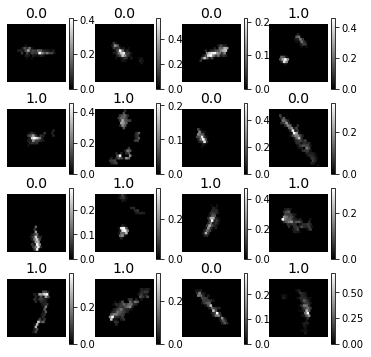

In [17]:
ys = pars_dict['CR_type'][test_inds]
fig = plt.figure(figsize=(6, 6))

for i in range(test_sample.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(test_sample[i, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.colorbar()
    plt.title(ys[i])

In [18]:
if 0:
    y_train = pars_dict['CR_type'][train_inds].reshape((len(train_inds), 1))
    y_test = pars_dict['CR_type'][test_inds].reshape((len(test_inds), 1))

    y_train_dataset = (tf.data.Dataset.from_tensor_slices(y_train).batch(batch_size))
    y_test_dataset = (tf.data.Dataset.from_tensor_slices(y_test).batch(batch_size))

In [19]:
#np.std(pars_dict['hillas_intensity'][:50]/200)

In [22]:
mean_prior_all = np.zeros((len(train_inds), latent_dim), dtype=np.float32)
logvar_prior_all = np.zeros((len(train_inds), latent_dim), dtype=np.float32)
if use_priors:
    mean_prior_all[:, 0] = pars_dict['CR_type'][train_inds]
    logvar_prior_all[:, 0] = -20.
    mean_prior_all[:, 1] = np.log10(pars_dict['true_energy'][train_inds])
    #mean_prior_all[:, 2] = 50 * pars_dict['hillas_width'][train_inds]
    #mean_prior_all[:, 3] = pars_dict['hillas_intensity'][train_inds] / 200
mean_prior_all = mean_prior_all.reshape((nbatch, batch_size, latent_dim))
logvar_prior_all = logvar_prior_all.reshape((nbatch, batch_size, latent_dim))   

In [69]:
print(nbatch)

291


Epoch: 19, Test set ELBO: 81.46 (0.01 diff), time/epoch: 3.2 s, tot time: 60.3 s


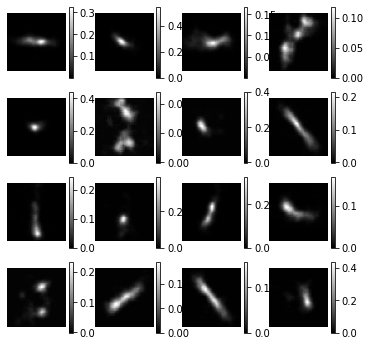

In [23]:
t_tot = 0
elbo_old = 0
elbo_thres = 0.03
#mean_prior = 
for epoch in range(1, epochs + 1):
#for epoch in range(epochs + 1, epochs + 5):
    start_time = time.time()
    for i, train_x in enumerate(train_dataset):
        mean_prior = tf.constant(mean_prior_all[i])
        logvar_prior = tf.constant(logvar_prior_all[i])
        if mean_prior.shape[0] != train_x.shape[0]:
            print('Problem here', train_y.shape, train_x.shape)
        train_step(model, train_x, optimizer, loss_method=loss_method, sigma_l2=sigma_l2,
                  mean_prior=mean_prior, logvar_prior=logvar_prior)
    end_time = time.time()
    t_tot += end_time - start_time

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        #y_test = next(iter(y_test_dataset)) # should we add it as prior for loss?
        loss(compute_loss(model, test_x, loss_method=loss_method, sigma_l2=sigma_l2,
                         mean_prior=0., logvar_prior=0.))
    elbo = loss.result()
    display.clear_output(wait=False)
    delbo = elbo_old - elbo
    print('Epoch: %i, Test set ELBO: %.2f (%.2f diff), time/epoch: %.1f s, tot time: %.1f s'
        % (epoch, elbo, delbo, end_time - start_time, t_tot))
    generate_and_save_images(model, epoch, test_sample, save=False, show=True)
    if np.abs(delbo) < elbo_thres:
        break
    else:
        elbo_old = elbo

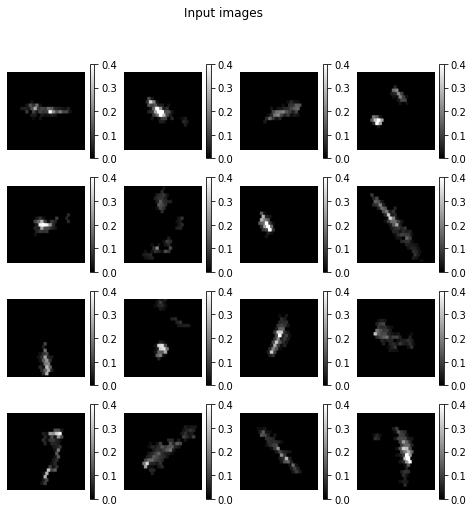

In [66]:
size = 8
v = 0.4
fig = plt.figure(figsize=(size, size))
for i in range(test_sample.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(test_sample[i, :, :, 0], cmap='gray', vmin=0, vmax=v)
    plt.axis('off')
    plt.colorbar()
plt.suptitle('Input images');

In [53]:
pred_images = predicted_images(model, test_sample)

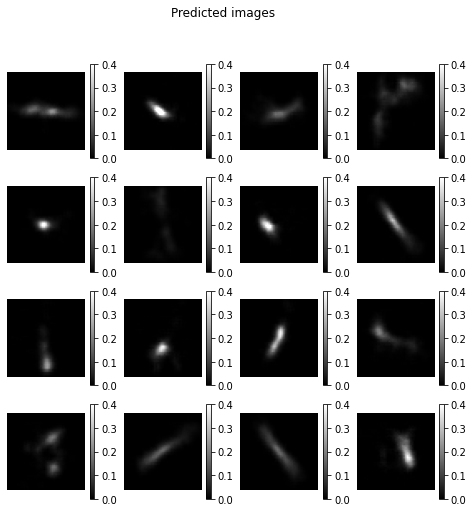

In [61]:
fig = plt.figure(figsize=(size, size))
for i in range(test_sample.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(pred_images[i, :, :, 0], cmap='gray', vmin=0, vmax=v)
    plt.axis('off')
    plt.colorbar()
plt.suptitle('Predicted images');


Text(0.5, 0.98, 'Image - model')

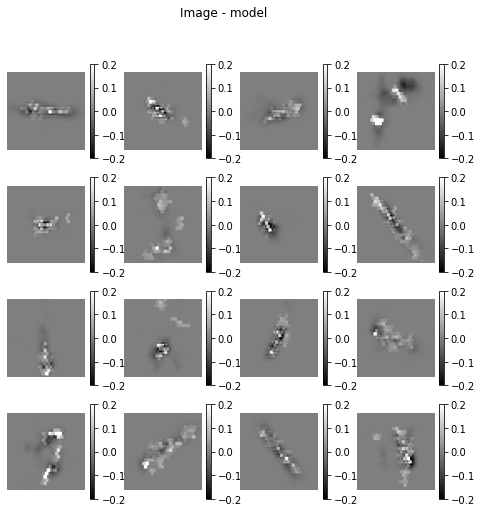

In [58]:
diff = test_sample - pred_images
fig = plt.figure(figsize=(size, size))
for i in range(test_sample.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(diff[i, :, :, 0], cmap='gray', vmin=-v/2, vmax=v/2)
    plt.axis('off')
    plt.colorbar()
plt.suptitle('Image - model')


In [28]:
animate = False
if animate:
    import tensorflow_docs.vis.embed as embed
    embed.embed_file(anim_file)

In [29]:
cdict

{'image_size': 47,
 'nkernels': [16, 32],
 'loss': 'l2',
 'sigma_l2': 0.1,
 'latent_dim': 10,
 'smax': 1000,
 'smin': 400,
 'epochs': 30}

In [30]:
# save the model
if save_model:
    save_vae_model(model, cdict)
#print(model_yaml)

Text(0.5, 0.98, 'Encoder')

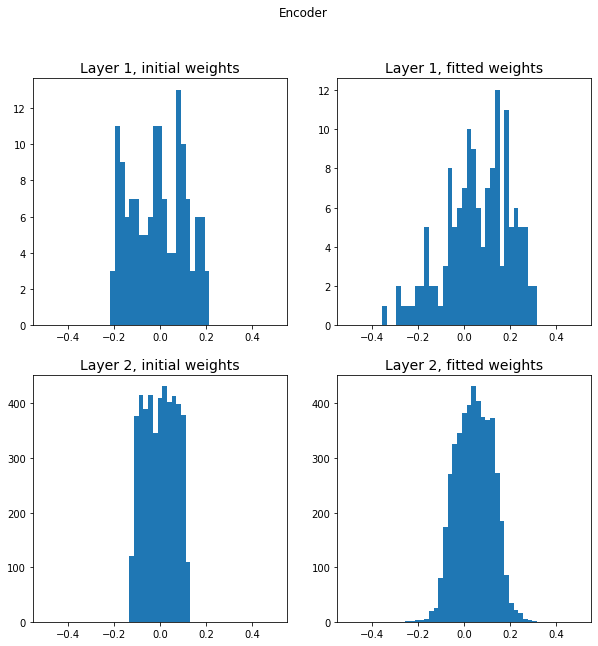

In [31]:
model_test = CVAE(latent_dim)
bins = np.linspace(-0.5, 0.5, 50)

plt.figure(figsize=(size, size))
plt.subplot(2, 2, 1)
plt.hist(np.array(model_test.encoder.weights[0]).flatten(), bins=bins)
plt.title('Layer 1, initial weights')
#plt.axis('off')

plt.subplot(2, 2, 2)
plt.hist(np.array(model.encoder.weights[0]).flatten(), bins=bins)
plt.title('Layer 1, fitted weights')

plt.subplot(2, 2, 3)
plt.hist(np.array(model_test.encoder.weights[2]).flatten(), bins=bins)
plt.title('Layer 2, initial weights')

plt.subplot(2, 2, 4)
plt.hist(np.array(model.encoder.weights[2]).flatten(), bins=bins)
plt.title('Layer 2, fitted weights')

plt.suptitle('Encoder')

Text(0.5, 0.98, 'Decoder')

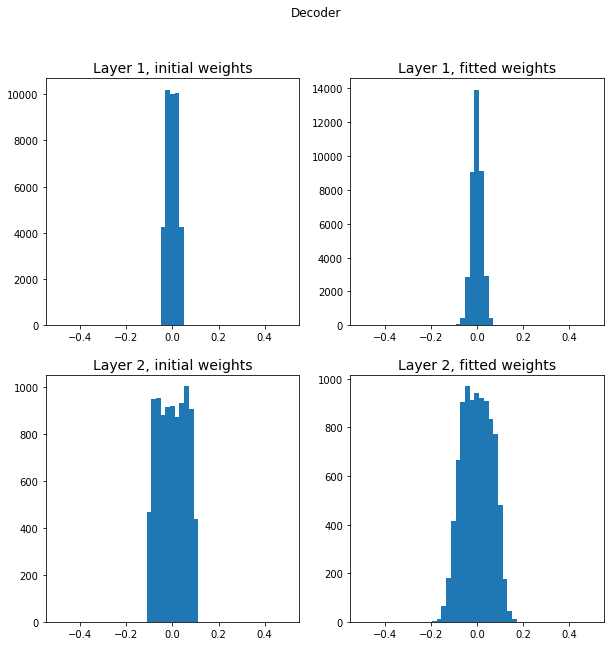

In [32]:
plt.figure(figsize=(size, size))
plt.subplot(2, 2, 1)
plt.hist(np.array(model_test.decoder.weights[0]).flatten(), bins=bins)
plt.title('Layer 1, initial weights')

plt.subplot(2, 2, 2)
plt.hist(np.array(model.decoder.weights[0]).flatten(), bins=bins)
plt.title('Layer 1, fitted weights')

plt.subplot(2, 2, 3)
plt.hist(np.array(model_test.decoder.weights[2]).flatten(), bins=bins)
plt.title('Layer 2, initial weights')
plt.subplot(2, 2, 4)
plt.hist(np.array(model.decoder.weights[2]).flatten(), bins=bins)
plt.title('Layer 2, fitted weights')

plt.suptitle('Decoder')

In [33]:
if latent_dim == 2:
    plot_latent_images(model, 30)

In [73]:
# latent coordinates of train and test datasets
xcl_train, log_z_var = model.encode(x_train)
xcl_test, log_z_var = model.encode(x_test)


In [74]:
if 0:
    # test loading the model
    mdl_load = load_vae_model(cdict)
    xcl_train_load, log_z_var = mdl_load.encode(x_train)
    xcl_test_load, log_z_var = mdl_load.encode(x_test)
    print('Saved and loaded encoder is OK:', np.array(xcl_train == xcl_train_load).all())

In [98]:
# CR classifiation
y_key = 'CR_type'
y_data = pars_dict[y_key]
y_train = y_data[train_inds]
y_test = y_data[test_inds]
#print(y_test)

bins = np.linspace(-5, 5, 100)
if 1:
    y_mask = np.array(y_test, dtype=bool)
    xs1 = np.array(xcl_test).T[:, y_mask] # protons
    xs2 = np.array(xcl_test).T[:, ~y_mask] # not protons
else:
    y_mask = np.array(y_train, dtype=bool)
    xs1 = np.array(xcl_train).T[:, y_mask] # protons
    xs2 = np.array(xcl_train).T[:, ~y_mask] # not protons


0.110332526 -0.028428255


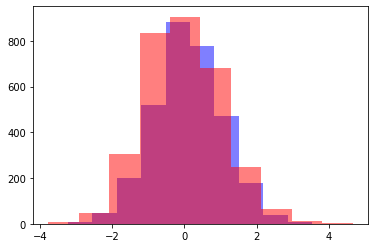

In [76]:
print(np.mean(xs1[0]), np.mean(xs2[0]))
plt.figure()
plt.hist(xs1[0], alpha=0.5, color='b');
plt.hist(xs2[0], alpha=0.5, color='r');

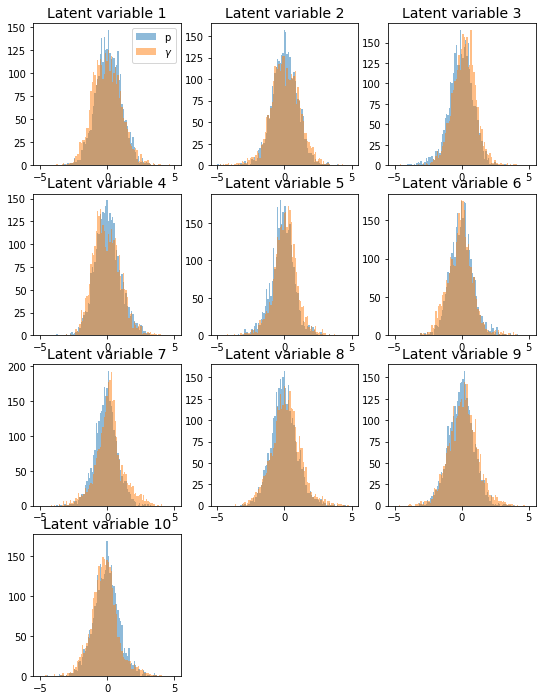

In [77]:


ncol = 3
nraw = int(np.ceil(latent_dim / ncol))
plt.figure(figsize=(ncol * 3, nraw * 3))
for i in range(latent_dim):
    plt.subplot(nraw, ncol, i + 1)
    #plt.figure()
    plt.hist(xs1[i], bins=bins, alpha=0.5, label='p')
    plt.hist(xs2[i], bins=bins, alpha=0.5, label='$\gamma$')
    if i == 0:
        plt.legend()
    plt.title('Latent variable %i' % (i+1))

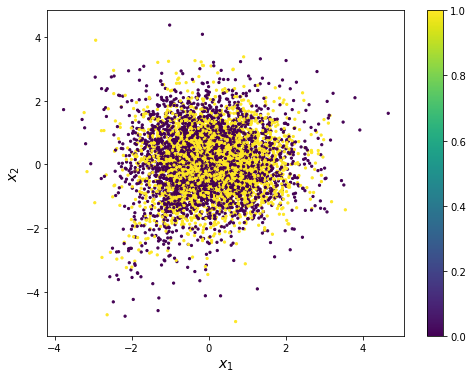

In [78]:
plot_label_clusters(xcl_test, y_test, inds=[0,1], s=5)

In [79]:
clf_dict = {}

In [80]:
# CR classification

# logistic regression training and testing
clf = LogisticRegression(random_state=0).fit(xcl_train, y_train)
print('Training score LR: %.4f' % clf.score(xcl_train, y_train))
print('Testing score LR: %.4f' % clf.score(xcl_test, y_test))
clf_dict['LR'] = clf

Training score LR: 0.5765
Testing score LR: 0.5824


In [81]:
# random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=4, random_state=0).fit(xcl_train, y_train)
print('Training score RF: %.4f' % clf.score(xcl_train, y_train))
print('Testing score RF: %.4f' % clf.score(xcl_test, y_test))
clf_dict['RF'] = clf

Training score RF: 0.6591
Testing score RF: 0.6361


In [91]:
# ROC curves
def true_positive(thres, probs, classes):
    pos = (probs > thres)
    true_pos = pos & classes
    return np.sum(true_pos) / np.sum(classes) # true positive / all true positive

def false_positive(thres, probs, classes):
    pos = (probs > thres)
    false_pos = pos & (~classes)
    return np.sum(false_pos) / np.sum(~classes) # false positive / all true negative


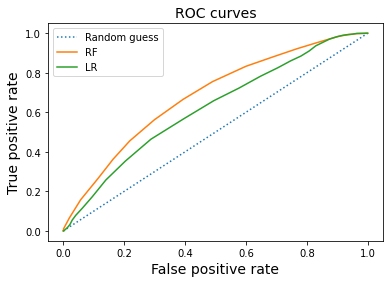

In [103]:
classes = y_test.astype(bool)
thresholds = np.arange(0.1, 0.91, 0.02)
plt.figure()
plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), ls=':', label='Random guess')
for name in ['RF', "LR"]:
    clf = clf_dict[name]
    probs = clf.predict_proba(xcl_test)[:,1]
    
    tpr = [true_positive(thres, probs, classes) for thres in thresholds]
    fpr = [false_positive(thres, probs, classes) for thres in thresholds]

    
    plt.plot(fpr, tpr, label=name)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves')
plt.legend()

In [83]:
# Energy reconstruction
y_key = 'true_energy'
y_data = pars_dict[y_key]
y_train = y_data[train_inds]
y_test = y_data[test_inds]
print(y_test)

[ 0.2137591   0.12700994  0.5859196  ...  0.21486396  0.48675078
 19.9804    ]


In [84]:
from sklearn.ensemble import RandomForestRegressor
# need to update sklearn
#rgr = RandomForestRegressor(n_estimators=50, criterion='squared_error', max_depth=4) 
rgr = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=4) 

In [85]:
from sklearn.neural_network import MLPRegressor
rgr = MLPRegressor(hidden_layer_sizes=(10, 10, 10), activation='relu', max_iter=1000)

In [86]:
rgr.fit(xcl_train, np.log(y_train))

MLPRegressor(hidden_layer_sizes=(10, 10, 10), max_iter=1000)

In [87]:
Etrain = np.exp(rgr.predict(xcl_train))
print(Etrain[:30])
print(y_train[:30])

[0.14791425 2.9044372  0.11361393 0.10488871 1.9339919  2.73729857
 0.12823391 0.21790631 0.3315396  7.64745976 1.61298823 4.00598925
 3.33669159 0.30833922 0.19759143 3.72306156 1.04053879 4.2762905
 0.15571723 0.20489324 0.34196636 0.72199373 2.4436654  1.41395896
 2.45057758 0.24677146 1.21970776 0.14553536 0.14086318 0.29296617]
[9.2690742e-01 7.1452749e-01 1.6860391e-01 1.8597685e-01 6.5614653e-01
 1.4627055e+00 7.1544290e-02 3.3724576e-02 1.6281509e-01 3.7644989e+00
 6.0458869e-01 1.9282850e+00 1.7248650e+00 1.2784259e+00 6.5297383e-01
 3.5499954e+01 9.4025046e-01 4.7652468e-01 9.2569895e-02 6.6690981e-02
 1.9367738e-01 1.0416321e+00 5.2589378e+00 7.4961561e-01 4.8462358e+00
 3.2502696e-02 8.9283407e-01 8.2154401e-02 4.4675715e-02 1.2742622e-01]


-0.02 +- 0.61


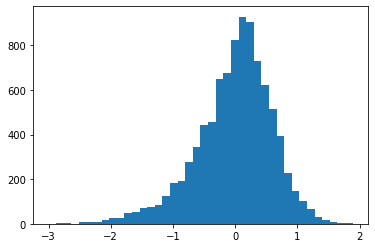

In [88]:
#Etest_pred = np.exp(rgr.predict(xcl_test))
#log10_ratio = np.log10(Etest_pred/y_test)
E_pred = np.exp(rgr.predict(xcl_train))
log10_ratio = np.log10(E_pred/y_train)
plt.hist(log10_ratio, bins=40)
print('%.2f +- %.2f' % (np.mean(log10_ratio), np.std(log10_ratio)))
#print(Etest[:30])
#print(y_test[:30])

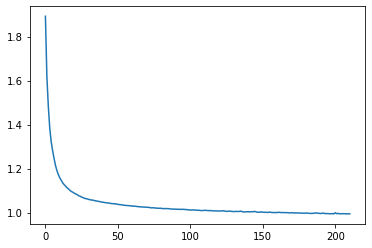

In [89]:
plt.plot(rgr.loss_curve_)